In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from holidays import US
import holidays
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, DMatrix
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate

import pandas as pd
import numpy as np
from datetime import datetime



df = pd.read_csv('/kaggle/input/us-dataset/day_sales_data_7_202408172214.csv')

/tmp/ipykernel_33/2929890645.py:27: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/us-dataset/day_sales_data_7_202408172214.csv')


In [12]:
df.isnull().sum()

org_code                    0
sd_sku                    307
sd_segment6              2519
sd_segment5              5242
sd_segment4              2519
sd_segment3              2519
sd_segment2              2519
sd_segment1              2519
currency                    0
purchase_date               0
sales_rank               3406
as_on_date_stock            3
current_stock            3059
total_items_sold            0
revenue                     0
gross_revenue           37830
total_promotion_cost    37830
keyword_impressions         0
keyword_cost                0
keyword_revenue             0
keyword_unitsold            0
keyword_clicks              0
return_units                0
dtype: int64

In [13]:

df['sd_sku'] = df['sd_sku'].astype(str)
df = df[
    ~df['sd_sku'].str.contains('missing') &
    ~df['sd_sku'].str.contains('UNKNOW') &
    ~df['sd_sku'].str.contains('found') &
    ~df['sd_sku'].str.contains('amzn') &
    ~df['sd_sku'].str.contains('Merge') &
    ~df['sd_sku'].str.contains('THM-PLLW-STR-SOFT-2PK-Q-stickerless') 
]


In [14]:
df = df.drop('sd_segment6', axis=1)
segment_columns = ['sd_segment5', 'sd_segment4', 'sd_segment3', 'sd_segment2','sd_segment1']
df[segment_columns] = df[segment_columns].fillna('unknown')

In [15]:
df = df.dropna(subset=['gross_revenue'])
promo_null = ['total_promotion_cost']
df[promo_null] = df[promo_null].fillna(0)

df = df.fillna({'as_on_date_stock': 0, 'current_stock': 0})

# Identify SKUs where all sales ranks are 0
skus_all_zero = df.groupby('sd_sku').filter(
    lambda x: all(x['sales_rank'] == 0)
)['sd_sku'].unique()

# Identify SKUs where all sales ranks are NaN
skus_all_nan = df.groupby('sd_sku').filter(
    lambda x: all(x['sales_rank'].isna())
)['sd_sku'].unique()

# Replace sales rank with -1 for SKUs where all ranks are 0
df.loc[df['sd_sku'].isin(skus_all_zero) & (df['sales_rank'] == 0), 'sales_rank'] = -1

# Replace sales rank with -1 for SKUs where all ranks are NaN
df.loc[df['sd_sku'].isin(skus_all_nan) & (df['sales_rank'].isna()), 'sales_rank'] = -1

# Replace the remaining 0 or NaN values using forward fill
df['sales_rank'] = df['sales_rank'].replace(0, np.nan).ffill()

In [16]:
df.isnull().sum()

org_code                0
sd_sku                  0
sd_segment5             0
sd_segment4             0
sd_segment3             0
sd_segment2             0
sd_segment1             0
currency                0
purchase_date           0
sales_rank              0
as_on_date_stock        0
current_stock           0
total_items_sold        0
revenue                 0
gross_revenue           0
total_promotion_cost    0
keyword_impressions     0
keyword_cost            0
keyword_revenue         0
keyword_unitsold        0
keyword_clicks          0
return_units            0
dtype: int64

In [17]:

# Assuming the original dataframe is called 'df'

# 1. Filter Data
df_usd = df[df['currency'] == 'USD'].copy()

# 2. Datetime Conversion
df_usd['purchase_date'] = pd.to_datetime(df_usd['purchase_date'])

# 3. Sort Data
df_usd.sort_values('purchase_date', inplace=True)

# 4. Create Date-Based Features
df_usd['month'] = df_usd['purchase_date'].dt.month
df_usd['year'] = df_usd['purchase_date'].dt.year
df_usd['day_of_week'] = df_usd['purchase_date'].dt.dayofweek
df_usd['is_weekend'] = df_usd['day_of_week'].isin([5, 6]).astype(int)

# Calculate days_since_start
start_date = df_usd['purchase_date'].min()
df_usd['days_since_start'] = (df_usd['purchase_date'] - start_date).dt.days



In [18]:
# Calculate Price and Cost Features
df_usd['item_price'] = df_usd['revenue'] / df_usd['total_items_sold']

# Replace zeros and infinities with NaN
df_usd['item_price'] = df_usd['item_price'].replace([0, float('inf'), float('-inf')], np.nan)

# Fill NaN values within each SKU using the nearest non-null value
#df_usd['item_price'] = df_usd.groupby('sd_sku')['item_price'].transform(lambda group: group.interpolate(method='nearest'))

# Display the final item_price column
#df_usd['item_price']

# Forward fill within each SKU group (use the previous non-null value)
df_usd['item_price'] = df_usd.groupby('sd_sku')['item_price'].transform(lambda x: x.ffill())
# Backward fill within each SKU group (use the next non-null value for any remaining nulls)
df_usd['item_price'] = df_usd.groupby('sd_sku')['item_price'].transform(lambda x: x.bfill())
# Display the final item_price column
df_usd['item_price']

127326     64.99
17967     199.99
332078     28.99
297100     69.99
236548     99.99
           ...  
377166    169.99
92471      27.99
14454     169.99
337440     19.99
358387     19.99
Name: item_price, Length: 338440, dtype: float64

In [19]:
df_usd['promotion_cost_per_item'] = df_usd['total_promotion_cost'] / df_usd['total_items_sold']
df_usd['ROAS'] = df_usd['keyword_revenue'] / df_usd['keyword_cost']

# 8. Normalize SKU Importance
df_usd['sku_importance'] = df_usd.groupby('sd_sku')['total_items_sold'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [20]:
def get_season_numeric(month):
    if pd.isna(month):
        return 0  # 0 for unknown or NaN
    month = int(month)
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Autumn
    elif month in [12, 1, 2]:
        return 4  # Winter
    else:
        return 0  # Unknown

# Apply the function
df_usd['season'] = df_usd['month'].map(get_season_numeric)

In [21]:
# 10. Encode Special Events
def get_event(date):
    if date in [pd.Timestamp('2023-07-12'), pd.Timestamp('2023-07-13'), 
                pd.Timestamp('2024-07-16'), pd.Timestamp('2024-07-17')]:
        return 1  # Prime Day
    elif date in [pd.Timestamp('2023-11-24'), pd.Timestamp('2024-11-29')]:
        return 2  # Black Friday
    elif date in [pd.Timestamp('2023-11-27'), pd.Timestamp('2024-12-02')]:
        return 3  # Cyber Monday
    else:
        return 0  # Other days

df_usd['event'] = df_usd['purchase_date'].map(get_event)


# 11. Encode Categorical Features
#categorical_features = ['sd_segment1', 'sd_segment2', 'sd_segment3', 'sd_segment4', 'sd_segment5']
#df_usd = pd.get_dummies(df_usd, columns=categorical_features, prefix=categorical_features)

In [22]:
from sklearn.preprocessing import LabelEncoder

# 11. Encode Categorical Features
categorical_features = ['sd_segment1', 'sd_segment2', 'sd_segment3', 'sd_segment4', 'sd_segment5']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    df_usd[feature] = le.fit_transform(df_usd[feature].astype(str))
    label_encoders[feature] = le
df_may = df_usd[df_usd['purchase_date'].dt.to_period('M') == '2024-05'].copy()

# Store the label encoders if needed for future use
# pickle.dump(label_encoders, open('label_encoders.pkl', 'wb'))

In [23]:
# Filter data from Jan 2023 to April 2024
df_train = df_usd[(df_usd['purchase_date'] >= '2023-01-01') & (df_usd['purchase_date'] <= '2024-04-30')].copy()

# Prepare features
features = ['total_promotion_cost', 'item_price', 'keyword_cost', 'promotion_cost_per_item', 
            'ROAS', 'year', 'month', 'day_of_week', 'is_weekend', 'sku_importance','event','season']

# Add one-hot encoded columns for sd_segment1, sd_segment2, sd_segment3
#segment_columns = [col for col in df_train.columns if col.startswith(('sd_segment1_', 'sd_segment2_', 'sd_segment3_'))]
#features.extend(segment_columns)

# Define the segment features
segment_features = ['sd_segment1', 'sd_segment2', 'sd_segment3', 'sd_segment4', 'sd_segment5']

# Add these features to the features list
features.extend(segment_features)

# Create a dictionary to map SKUs to integers
sku_to_int = {sku: i for i, sku in enumerate(df_usd['sd_sku'].unique())}

#TODO
# Encode sd_sku
df_train['sd_sku_encoded'] = df_train['sd_sku'].map(sku_to_int)
features.append('sd_sku_encoded')


In [24]:
# Clean the data
for feature in features:
    df_train[feature] = pd.to_numeric(df_train[feature], errors='coerce')
    df_train[feature] = df_train[feature].replace([np.inf, -np.inf], np.nan)
    df_train[feature] = df_train[feature].fillna(df_train[feature].mean())


# Prepare X and y
X = df_train[features]
y = df_train['total_items_sold']

##TODO-RANDOM STATE
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(random_state=42, missing=np.nan)
model.fit(X_train, y_train)

# Validate the model
y_pred_val = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 0.16458069639551548
R-squared Score: 0.967359766978182



Results Table for May 2024 (sorted by predicted sales):
| SKU                                    |   Act_Sales |   Pred_Sales |   Diff |   Price |   KW_Cost |   Promo_Cost |   Year |   Month |   Day_Week |   Is_Wknd | Event   |   Season |
|:---------------------------------------|------------:|-------------:|-------:|--------:|----------:|-------------:|-------:|--------:|-----------:|----------:|:--------|---------:|
| THM-BLNKT-DRB16-White-K                |         749 |          656 |    -93 |   63.35 |     72.55 |        65.67 |   2024 |       7 |          0 |         0 | 0, 1    |        2 |
| THM-BLNKT-DRB16-White-Q                |         567 |          567 |      0 |   62.43 |     63.63 |        51.13 |   2024 |       7 |          0 |         0 | 0, 1    |        2 |
| THM-1200-SLD-White-K                   |         370 |          381 |     11 |   197.4 |    430.92 |        97.53 |   2024 |       7 |          0 |         0 | 0, 1    |        2 |
| THM-BLNKT-DRB16-Beige-K   

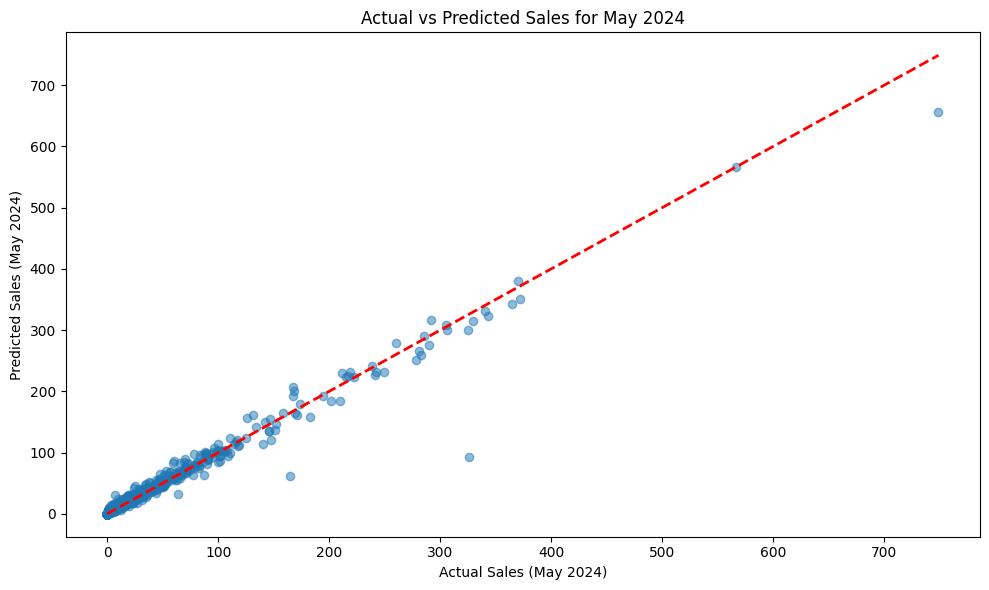

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Assume df_usd, features, X, model, and sku_to_int are already defined

# Prepare May 2024 data for prediction
df_may = df_usd[df_usd['purchase_date'].dt.to_period('M') == '2024-07'].copy()

# Encode sd_sku for May data
df_may['sd_sku_encoded'] = df_may['sd_sku'].map(lambda x: sku_to_int.get(x, len(sku_to_int)))

# Clean May data
for feature in features:
    if feature in df_may.columns:
        df_may[feature] = pd.to_numeric(df_may[feature], errors='coerce')
        df_may[feature] = df_may[feature].replace([np.inf, -np.inf], np.nan)
        df_may[feature] = df_may[feature].fillna(X[feature].mean())  # Use training data mean for filling NaN

X_may = df_may[features]

# Predict sales for May 2024
y_pred_may = model.predict(X_may)

# Round off predictions
y_pred_may = y_pred_may.round().astype(int)

# Create results table for May
results = pd.DataFrame({
    'sku': df_may['sd_sku'],
    'actual_sales_may': df_may['total_items_sold'],
    'predicted_sales_may': y_pred_may
})

# Add all features to the results DataFrame
for feature in features:
    results[feature] = df_may[feature]

# Group by SKU and calculate aggregates
agg_dict = {
    'actual_sales_may': 'sum',
    'predicted_sales_may': 'sum',
}

# Add aggregation method for each feature
for feature in features:
    if feature in ['year', 'month', 'day_of_week', 'is_weekend','season']:
        agg_dict[feature] = 'first'  # For categorical features, take the first value
    elif feature in ['event']:
        agg_dict[feature] = lambda x: ', '.join(set(x.astype(str)))  # Convert to string before joining
    else:
        agg_dict[feature] = 'mean'  # For numerical features, take the mean

results_grouped = results.groupby('sku').agg(agg_dict).reset_index()

# Calculate the difference
results_grouped['difference'] = results_grouped['predicted_sales_may'] - results_grouped['actual_sales_may']

# Sort by predicted sales for May in descending order
results_sorted = results_grouped.sort_values('predicted_sales_may', ascending=False)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


# Redefine the column name map to include all features
column_name_map = {
    'sku': 'SKU',
    'actual_sales_may': 'Act_Sales',
    'predicted_sales_may': 'Pred_Sales',
    'difference': 'Diff',
    'item_price': 'Price',
    'keyword_cost': 'KW_Cost',
    'total_promotion_cost': 'Promo_Cost',
    'year': 'Year',
    'month': 'Month',
    'day_of_week': 'Day_Week',
    'is_weekend': 'Is_Wknd',
    'event': 'Event',
    'season': 'Season'
}

# Add any missing features to the column_name_map
for feature in features:
    if feature not in column_name_map:
        column_name_map[feature] = feature[:5]  # Use the first 5 characters if no short version is specified

# Rename the columns
results_sorted = results_sorted.rename(columns=column_name_map)

# Reorder the columns
column_order = ['SKU', 'Act_Sales', 'Pred_Sales', 'Diff', 'Price', 'KW_Cost', 'Promo_Cost', 'Year', 'Month', 'Day_Week', 'Is_Wknd', 'Event', 'Season']
results_sorted = results_sorted[column_order]

# Round the numeric columns to 2 decimal places
numeric_columns = results_sorted.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    results_sorted[col] = results_sorted[col].round(2)

# Convert boolean columns to 'Yes'/'No'
bool_columns = results_sorted.select_dtypes(include=[bool]).columns
for col in bool_columns:
    results_sorted[col] = results_sorted[col].map({True: 'Yes', False: 'No'})

# Format the 'Diff' column to show sign
results_sorted['Diff'] = results_sorted['Diff'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}")

# Generate a neat, structured table
table = tabulate(results_sorted, headers='keys', tablefmt='pipe', numalign='right', stralign='left', showindex=False)

print("\nResults Table for May 2024 (sorted by predicted sales):")
print(table)

# Optionally, save the results to a CSV file
results_sorted.to_csv('may_2024_sales_prediction_results.csv', index=False)

# ... (keep the plotting code as is)


# Plot actual vs predicted sales for May
plt.figure(figsize=(10, 6))
plt.scatter(results_sorted['Act_Sales'], results_sorted['Pred_Sales'], alpha=0.5)
plt.plot([0, results_sorted['Act_Sales'].max()], [0, results_sorted['Act_Sales'].max()], 'r--', lw=2)
plt.xlabel('Actual Sales (May 2024)')
plt.ylabel('Predicted Sales (May 2024)')
plt.title('Actual vs Predicted Sales for May 2024')
plt.tight_layout()
plt.show()